In [76]:
%load_ext autoreload

In [85]:
%autoreload

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import csv
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from gensim.models import Phrases
assert gensim.models.doc2vec.FAST_VERSION == 1, "this will be painfully slow otherwise"
import nltk, re
import datetime
import random
import multiprocessing
from ast import literal_eval
import pickle
from tqdm import tqdm
from nltk.stem.porter import PorterStemmer
from scipy.cluster.hierarchy import dendrogram, linkage
#%matplotlib inline

In [2]:
from parameter_search import util
from modeling import functions

In [4]:
data_path = "E:/dataset/Amazon/"
result_path = "E:/dataset/MasterThesis/FINAL/"
save_path = "E:/dataset/MasterThesis/FINAL/preprocess_data/"
model_path = "E:/dataset/MasterThesis/FINAL/doc2vec/"
category_list = ["Electronics"]

In [6]:
for category in category_list:
    data = pd.read_csv(save_path + "preprocess_complete_" + category + ".csv")
    data['preprocessed'] = data.preprocessed.apply(lambda row: literal_eval(row))

In [12]:
data.head()

,reviewTime,asin,reviewerID,overall,helpful,reviewText,title,brand,reviewSentence,sent_length,reviewSentence_tagged,preprocessed
0,2013-07-21,B00CM0XHNS,A372YX80GGM7DR,5.0,576,"Ok, so I didn't buy this on Amazon, as I didn'...",Ultimate Ears BOOM Wireless Bluetooth Speaker ...,Logitech,"[""Ok, so I didn't buy this on Amazon, as I did...",58,"[[('Ok', 'NNP'), (',', ','), ('so', 'IN'), ('I...","[[ok, so, i, did, n't, buy, this, on, amazon, ..."
1,2013-05-19,B00BQ5RY1G,A1BG2Z071TYO7P,2.0,522,I received a Harmony Ultimate from Logitech be...,Logitech Harmony Ultimate Remote with Customiz...,Logitech,['I received a Harmony Ultimate from Logitech ...,27,"[[('I', 'PRP'), ('received', 'VBD'), ('a', 'DT...","[[i, received, a, harmony, ultimate, from, log..."
2,2013-12-16,B00EZ9XG62,AELAESM03451,1.0,290,This review is for the iPad Air keyboard. I ha...,Logitech Ultrathin Keyboard Cover for iPad Air...,Logitech,"['This review is for the iPad Air keyboard.', ...",23,"[[('This', 'DT'), ('review', 'NN'), ('is', 'VB...","[[this, review, is, for, the, ipad, air, keybo..."
3,2013-01-21,B0099SMFVQ,A36CMGR5ELUM34,5.0,283,Design: Very well put together. Elegant and th...,Logitech Bluetooth Illuminated Keyboard K810 f...,Logitech,"['Design: Very well put together.', 'Elegant a...",28,"[[('Design', 'NN'), (':', ':'), ('Very', 'RB')...","[[design, very, well, put, together], [elegant..."
4,2013-07-29,B00CM0XHNS,A9TETE58A7JR3,3.0,260,"So, I've been testing a few bluetooth speakers...",Ultimate Ears BOOM Wireless Bluetooth Speaker ...,Logitech,"[""So, I've been testing a few bluetooth speake...",57,"[[('So', 'RB'), (',', ','), ('I', 'PRP'), (""'v...","[[so, i, been, testing, a, few, bluetooth, spe..."


In [17]:
sentence_list = []
brand_list = []
for index, row in data.iterrows():
    review = [word for sentence in row['preprocessed'] for word in sentence]
    brand_list.append(row['brand']) 
    sentence_list.append(review)
    
documents, bigram = util.make_documents(sentence_list, brand_list, tagby = False)

In [24]:
with open(result_path  + category + '_documents.pkl', 'wb') as f:
    pickle.dump(documents, f)

with open(result_path  + category + '_bigrams.pkl', 'wb') as f:
    pickle.dump(bigram, f)

#### 데이터 탐색

In [22]:
#리뷰당 평균 token 수
tokens_per_review = []
review_length = []
for doc in tqdm(documents):
    tokens_per_review.append(doc.words )
    review_length.append(len(doc.words))
    
total = [word for sent in tokens_per_review for word in sent]

100%|█████████████████████████████████████████████████████████████████████| 250000/250000 [00:00<00:00, 1195022.41it/s]


In [23]:
#총 token 수
print("total token is ", len(total))

t_corpus = nltk.Text(total)
t_freq = nltk.FreqDist(t_corpus)

# unique 한 token 수
print("unique token is ", len(t_freq.keys()))

# total word frequency
df = DataFrame(columns=[['word','freq']])
for word_tup in t_freq.most_common(100):
    df.loc[len(df)] = word_tup[0], t_freq[word_tup[0]]
df.to_csv(result_path + "total_word_freq.csv", index=False)

# 저장
with open(result_path + category + '_total_freq_dist.pkl', 'wb') as f:
    pickle.dump(t_freq, f)
    
#bigram 형태소 분석해서 형용사만 추출
selected = []
re_adj = re.compile('[JJ.*]')
re_verb = re.compile('[VB.*]')
re_adverb = re.compile('[RB.*]')
st = PorterStemmer()
for doc in tqdm(documents):
    pos = nltk.pos_tag(doc.words)
    pos = [tup[0] for tup in pos if re_adj.match(tup[1]) or re_verb.match(tup[1]) or re_adverb.match(tup[1])]
    selected.append(pos)
    
with open(result_path + category + '_adv_adj_verb.pkl', 'wb') as f:
    pickle.dump(selected, f)

total token is  26513023
unique token is  140447


100%|█████████████████████████████████████████████████████████████████████████| 250000/250000 [25:49<00:00, 161.39it/s]


In [30]:
# avg number of tokens in review:
length = [len(review) for review in tokens_per_review]
print("평균 token 개수는 : ", np.mean(np.array(length))

평균 token 개수는 :  106.052092


### 여기서부터 시작

In [7]:
# 저장한거 불러오기
with open(result_path + category + '_adv_adj_verb.pkl', 'rb') as f:
    selected = pickle.load(f)

# documents for doc2vec
with open(result_path  + category + '_documents.pkl', 'rb') as f:
    documents = pickle.load(f)

# bigrams
with open(result_path  + category + '_bigrams.pkl', 'rb') as f:
    bigram = pickle.load(f)
    
# total_freq_dist
with open(result_path + category + '_total_freq_dist.pkl', 'rb') as f:
    t_freq = pickle.load(f)

In [33]:
sizes = 500
window = 2
alpha, min_alpha, passes = (0.02, 0.001, 10)
alpha_delta = (alpha-min_alpha)/passes

model = Doc2Vec(dm=1, dm_mean=1, min_count=50, sample=1e-5, seed=1, workers=multiprocessing.cpu_count(),
                window=window, size=sizes, alpha=0.025, min_alpha=0.025)
model.build_vocab(documents)

for epoch in range(passes):
    start = time.time()
    random.shuffle(documents)
    model.train(documents)
    model.alpha -= alpha_delta  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay
    end = time.time()
    t = end-start
    print("size : %s, window : %s, epoch : %s, time : %i"%(sizes, window, epoch, t))

model.save('E:/dataset/MasterThesis/FINAL/final_model/' + 'final_model')

size : 500, window : 2, epoch : 0, time : 121
size : 500, window : 2, epoch : 1, time : 116
size : 500, window : 2, epoch : 2, time : 114
size : 500, window : 2, epoch : 3, time : 116
size : 500, window : 2, epoch : 4, time : 116
size : 500, window : 2, epoch : 5, time : 117
size : 500, window : 2, epoch : 6, time : 115
size : 500, window : 2, epoch : 7, time : 116
size : 500, window : 2, epoch : 8, time : 118
size : 500, window : 2, epoch : 9, time : 117


In [8]:
model = Doc2Vec.load('E:/dataset/MasterThesis/FINAL/final_model/final_model')

In [9]:
model.docvecs.most_similar('Samsung')

[('Acer', 0.21681271493434906),
 ('HP', 0.15814197063446045),
 ('Toshiba', 0.14184918999671936),
 ('Panasonic', 0.1363077461719513),
 ('LG', 0.13327369093894958),
 ('Sony', 0.10771286487579346),
 ('Google', 0.10767678916454315),
 ('Apple', 0.09981850534677505),
 ('Dell', 0.09882251918315887),
 ('Lenovo', 0.08677772432565689)]

In [10]:
model.docvecs.most_similar('Canon')

[('Nikon', 0.3931809663772583),
 ('Panasonic', 0.3004111051559448),
 ('Sony', 0.2920460104942322),
 ('Neewer', 0.2474614977836609),
 ('Case Logic', 0.14061112701892853),
 ('Garmin', 0.10069601237773895),
 ('SanDisk', 0.10013118386268616),
 ('eForCity', 0.09353649616241455),
 ('Pyle', 0.08068801462650299),
 ('SIB', 0.07400496304035187)]

In [11]:
model.docvecs.most_similar('Apple')

[('Roku', 0.19229714572429657),
 ('Lenovo', 0.16256362199783325),
 ('Western Digital', 0.1515151858329773),
 ('Google', 0.1501147449016571),
 ('Seagate', 0.1326066553592682),
 ('Dell', 0.12793442606925964),
 ('Asus', 0.12282544374465942),
 ('Griffin Technology', 0.1175394207239151),
 ('Crucial', 0.11734864115715027),
 ('Acer', 0.11663855612277985)]

In [12]:
model.most_similar([model.docvecs['Samsung']])

[('samsung', 0.25117596983909607),
 ('picture_quality', 0.1840740442276001),
 ('black_levels', 0.18037819862365723),
 ('smart_hub', 0.17926350235939026),
 ('tvs', 0.1786607801914215),
 ('superb', 0.16777878999710083),
 ('led_hdtv', 0.16741713881492615),
 ('looks', 0.16712906956672668),
 ('r8000', 0.16522666811943054),
 ('smart_tv', 0.16350339353084564)]

In [13]:
model.most_similar([model.docvecs['Canon']])

[('shoot', 0.2592770457267761),
 ('sx170', 0.25029176473617554),
 ('s90', 0.2408294677734375),
 ('t1i', 0.23888173699378967),
 ('dlsr', 0.22236625850200653),
 ('canon_t2i', 0.21338412165641785),
 ('canon', 0.20233984291553497),
 ('low_light', 0.20198088884353638),
 ('xsi', 0.1994638442993164),
 ('shots', 0.19552606344223022)]

In [14]:
model.most_similar([model.docvecs['Apple']])

[('apple', 0.2864070534706116),
 ('ipad', 0.2345629334449768),
 ('ipad_mini', 0.216627836227417),
 ('iphone', 0.21085487306118011),
 ('generation', 0.19698961079120636),
 ('ipad3', 0.19526898860931396),
 ('macbook', 0.19149050116539001),
 ('gen', 0.18824860453605652),
 ('imac', 0.18307974934577942),
 ('itunes', 0.17745235562324524)]

In [52]:
functions.extract_sim_words(model, "Canon", result_path, t_freq, 100, save=True, topn=100)
functions.extract_sim_words(model, "Apple", result_path, t_freq, 100, save=True, topn=100)
functions.extract_sim_words(model, "Samsung", result_path, t_freq, 100, save=True, topn=100)

functions.extract_sim_brand(model, "Canon", result_path, save=True, topn=30)
functions.extract_sim_brand(model, "Apple", result_path, save=True, topn=30)
functions.extract_sim_brand(model, "Samsung", result_path, save=True, topn=30)

In [22]:
brand_list, doc_arr = functions.clustering(model)

num of securities : 50, num of dimension : 500


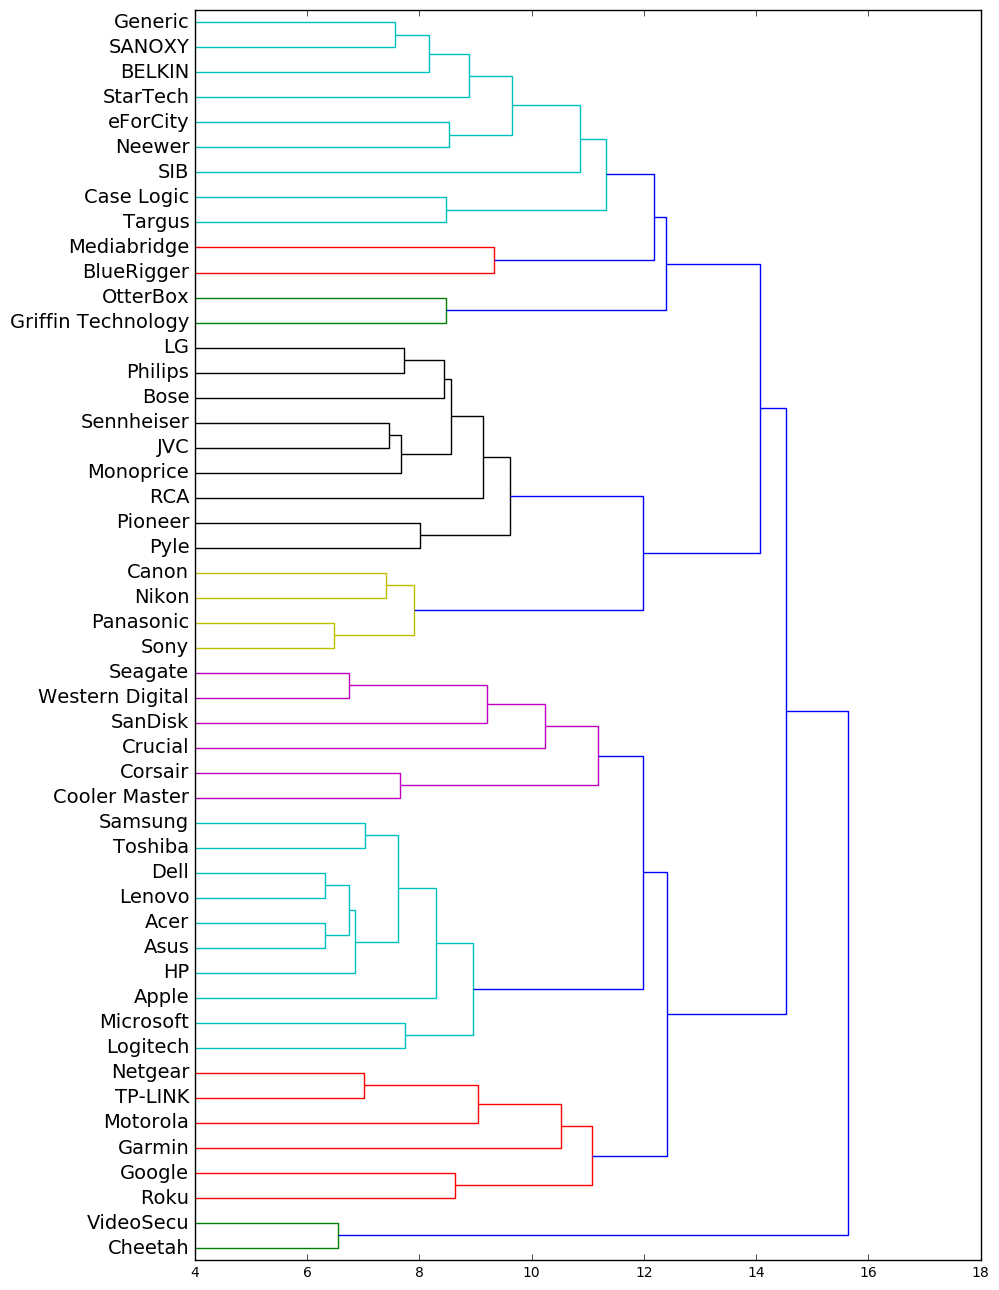

In [33]:
#cosine similarity 와 Ward's minimum variance method 방법을 이용한 hierarchical agglomerative clustering
Z = linkage(doc_arr, method='ward', metric='euclidean')
plt.figure(figsize=(10, 13))
dendrogram(Z,
           orientation='right',
        leaf_rotation=0.,  # rotates the x axis labels
        leaf_font_size=14.,  # font size for the x axis labels
        labels=brand_list,
           color_threshold = 11.5,
)
plt.tight_layout()
plt.xlim([4,18])
plt.savefig(result_path + "Visualization/dendrogram_vertical.png", dpi=300)
# plt.ylim([4,18])

plt.show()

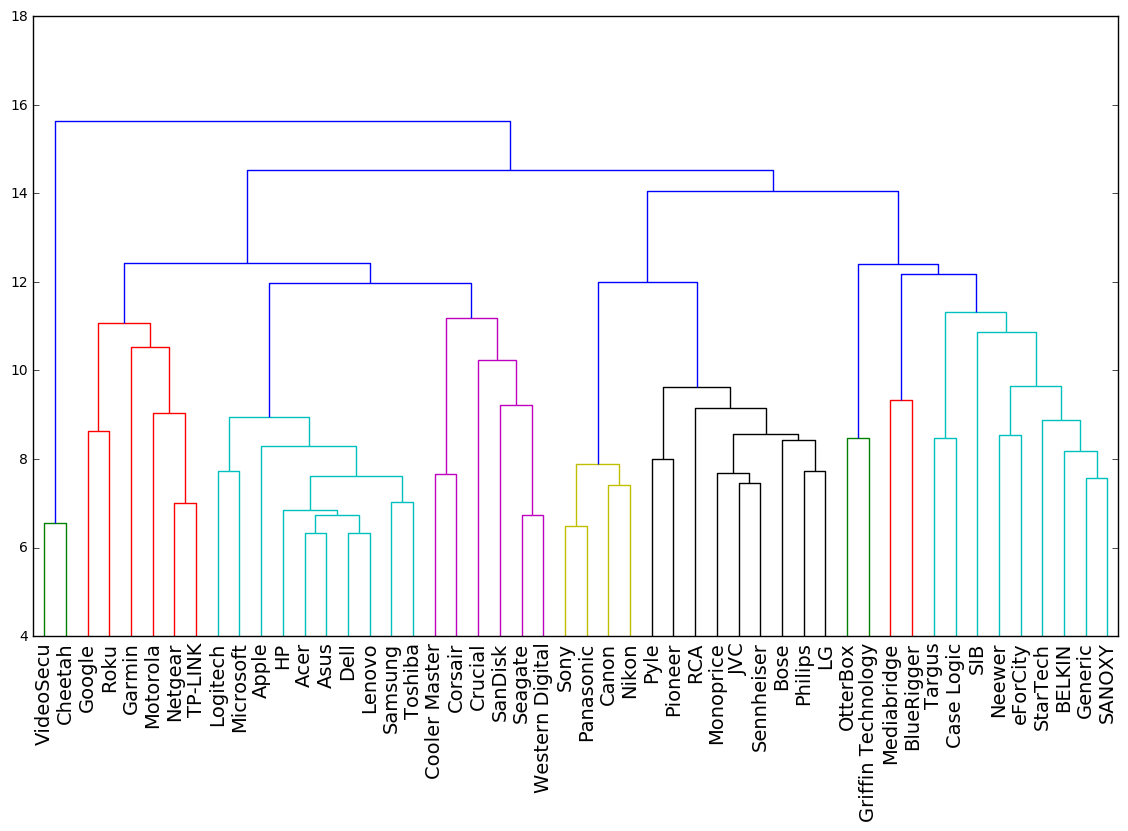

In [182]:
#cosine similarity 와 Ward's minimum variance method 방법을 이용한 hierarchical agglomerative clustering
Z = linkage(doc_arr, method='ward', metric='euclidean')
plt.figure(figsize=(14, 8))
dendrogram(Z,
           orientation='top',
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=14.,  # font size for the x axis labels
        labels=brand_list,
           color_threshold = 11.5,
)
plt.savefig(result_path + "Visualization/dendrogram.png", dpi=300)
plt.ylim([4,18])
plt.show()

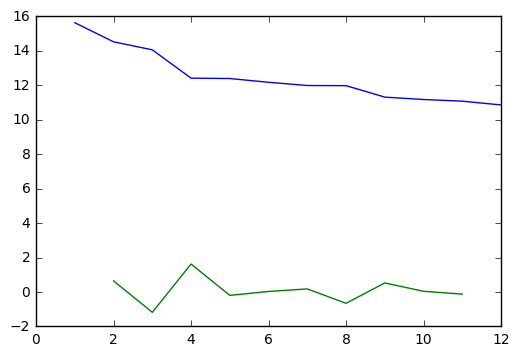

clusters: 4


In [64]:
last = Z[-12:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

In [63]:
#dendrogram 결과를 반영해 각 cluster labeling
from scipy.cluster.hierarchy import fcluster
clusters_s = fcluster(Z, 11.5, criterion='distance')
print(len(set(clusters_s)))

9


In [66]:
df_result = pd.DataFrame()
df_result['Name'] = brand_list
df_result['Cluster'] = clusters_s

In [186]:
# 7,8,9 번 cluster를 7로 통합
df_result.ix[df_result.Cluster >= 8, 'Cluster'] = 7

In [188]:
cluster_idx = [1,2,3,4,5,6,7]
words_df_lst=[]
for idx in cluster_idx:
    mean_vec = functions.cal_mean_cluster(df_result, idx, model)
    top_words_df = functions.print_result(mean_vec, model, t_freq, 100, topn=100)
    words_df_lst.append(top_words_df)
    top_words_df.to_csv(result_path + 'simWithCluster/cluster_{0:02d}.csv'.format(idx))

In [189]:
result = pd.concat([df for df in words_df_lst], axis=1)
result.to_csv(result_path + 'simWithCluster/sim_words_종합.csv', index=False)

#### 유사 단어 추출

In [72]:
camera = (model['camera'] + model['cameras'])/2
model.docvecs.most_similar([camera])

[('Canon', 0.2161141037940979),
 ('Sony', 0.2122315764427185),
 ('Nikon', 0.19436681270599365),
 ('Panasonic', 0.18292585015296936),
 ('eForCity', 0.06187775358557701),
 ('Garmin', 0.0534946471452713),
 ('Neewer', 0.050085581839084625),
 ('SanDisk', 0.04995618015527725),
 ('Case Logic', 0.04029814153909683),
 ('Asus', 0.03306621313095093)]

In [73]:
earphone = (model['earphone'] + model['headphone'])/2
model.docvecs.most_similar([earphone])

[('Sennheiser', 0.22563807666301727),
 ('Monoprice', 0.1348395049571991),
 ('JVC', 0.12586744129657745),
 ('Bose', 0.11198298633098602),
 ('Cooler Master', 0.08827805519104004),
 ('eForCity', 0.07362330704927444),
 ('Griffin Technology', 0.06146623194217682),
 ('Logitech', 0.06020241975784302),
 ('SIB', 0.057839494198560715),
 ('Philips', 0.056945279240608215)]

In [18]:
computer = (model['pc'] + model['laptop'])/2
model.docvecs.most_similar([computer])

[('HP', 0.16228224337100983),
 ('Toshiba', 0.12794044613838196),
 ('Dell', 0.10451081395149231),
 ('Acer', 0.09674297273159027),
 ('Lenovo', 0.08228749781847),
 ('Targus', 0.06836501508951187),
 ('StarTech', 0.06813840568065643),
 ('Crucial', 0.06552143394947052),
 ('Seagate', 0.06514821946620941),
 ('Mediabridge', 0.06356323510408401)]

In [19]:
functions.save_brand_sim(model, earphone, 'earphone', result_path, 10)
functions.save_brand_sim(model, camera, 'camera', result_path, 10)
functions.save_brand_sim(model, computer, 'computer', result_path, 10)

NameError: name 'earphone' is not defined

#### 전체 문서에서 단어 분포 추출

In [195]:
dic_doc = {}
for word in model.index2word:
    dic_doc[word] = 1
total_word_list = []
for doc in documents:
    word_list = [word for word in doc.words if word in dic_doc]
    total_word_list.append(word_list)

In [198]:
#각 브랜드에서 많이 등장한 단어
brands = ["Samsung","Microsoft","Canon"]
for brand in brands:
    review, freq = functions.brand_freq(documents, total_word_list, brand)
    top_freq_words = freq.most_common(100)
    df = DataFrame(columns=[["word","count"]])
    for top_words in top_freq_words:
        df.loc[len(df)] = top_words[0], freq[top_words[0]]
    df = df.sort_values("count", ascending=False)
    df.to_csv(result_path + 'tf-idf/' + brand + '_adj_adv_verb.csv', index=False)

#### TF-IDF와 비교

* tf-idf  결과

In [196]:
df_tfidf = functions.tf_idf(documents, total_word_list, brand_list, max_feature = 5000)
df_tfidf.to_csv(result_path + '/tf-idf/tf-idf-score_total.csv')

* 내 방법으로 scoring 결과

In [115]:
# 전체 단어에서 추출
df_score = functions.scoring(model, brand_list, total_word_list, topn=5000)
brands = ["Samsung", "Canon", "Apple","Microsoft"]
for brand in brands:
    df_keywords = functions.extract_words_by_score(df_score, brand, documents, total_word_list, min_count = 100)
    df_keywords.to_csv(result_path + '/scoring_keywords/' + brand + '_KeywordsByScore_total.csv', index=False)

In [116]:
# 형용사, 동사, 부사를 이용해 추출한 결과
df_score = functions.scoring(model, brand_list, selected, topn=5000)
brands = ["Samsung", "Canon", "Apple","Microsoft"]
for brand in brands:
    df_keywords = functions.extract_words_by_score(df_score, brand, documents, selected, min_count = 100)
    df_keywords.to_csv(result_path + '/scoring_keywords/' + brand + '_KeywordsByScore_AdjVerbAdv.csv', index=False)

#### T-SNE

In [192]:
import tsne
import random
import numpy
numpy.random.seed(1)
X = np.zeros((len(brand_list), model.vector_size))
for i, brand in enumerate(brand_list):
    X[i] = model.docvecs[brand].flatten()
numpy.random.seed(1)
t_sne = tsne.tsne(X,initial_dims = 10, perplexity = 5, iteration=1000)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 50
Mean value of sigma:  1.82188068969
Iteration 10, error is 18.549927787
Iteration 20, error is 16.4663633022
Iteration 30, error is 17.2610762711
Iteration 40, error is 16.2274554587
Iteration 50, error is 16.0119833841
Iteration 60, error is 17.3002403705
Iteration 70, error is 18.8604231105
Iteration 80, error is 17.1770268066
Iteration 90, error is 19.2019158376
Iteration 100, error is 21.1232174839
Iteration 110, error is 3.10703522973
Iteration 120, error is 2.80495962986
Iteration 130, error is 2.65736141301
Iteration 140, error is 2.50664628933
Iteration 150, error is 2.38855495755
Iteration 160, error is 2.27178519598
Iteration 170, error is 2.16382652676
Iteration 180, error is 2.11514081433
Iteration 190, error is 2.03373814703
Iteration 200, error is 1.92314364623
Iteration 210, error is 1.85454256705
Iteration 220, error is 1.76519747738
Iteration 230, error is 1.6529753

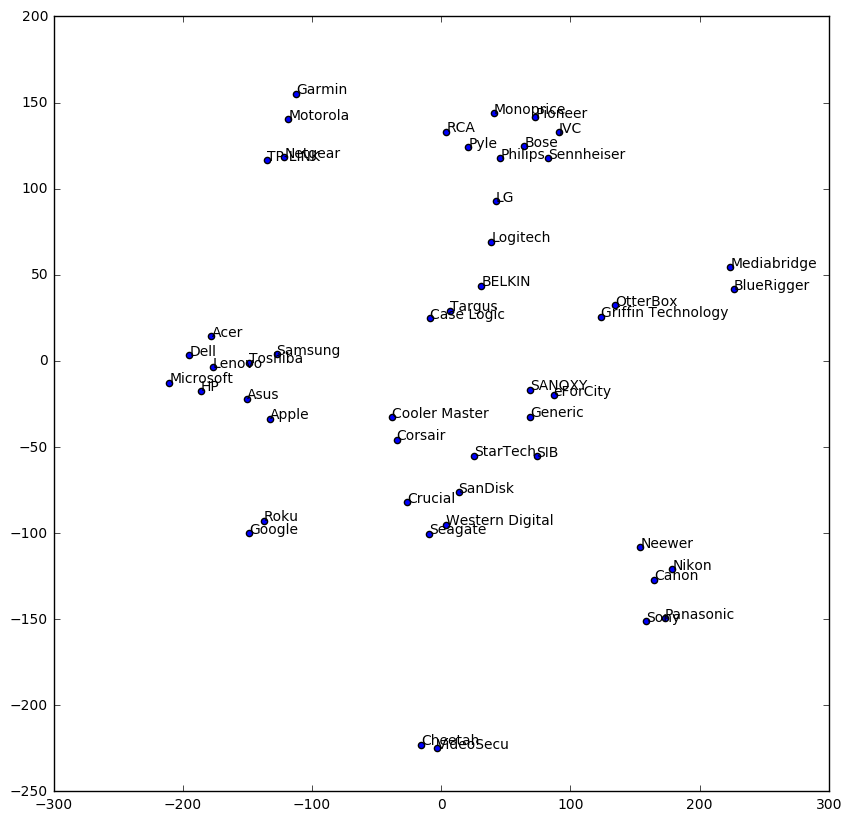

In [193]:
fig = plt.figure(figsize=(10,10))
plt.scatter(t_sne[:,0], t_sne[:,1])
for i, brand in enumerate(brand_list):
    plt.annotate(brand, (t_sne[i,0],t_sne[i,1]))
plt.show()

In [194]:
#tsne 결과를 저장
df = DataFrame(columns=('brand','dim_1','dim_2'))
for i, brand in enumerate(brand_list):
    df.loc[i] = [brand, t_sne[i,0],t_sne[i,1]]

df.to_csv(result_path + 'Visualization/t-sne_result.csv', index=False)